# Importing the required libraries

In [1]:
import os, cv2, random, time, shutil, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import squarify

# Finding the contents of the directory

In [2]:
files_type = {}
files_extension = {}
for dirname, _, filenames in os.walk('/root/project/data'):
    for filename in filenames:
        if '.' in filename:
            extension = filename[filename.find('.')+1:]
            files_extension[extension] = files_extension.get(extension, 0) + 1
            if extension not in files_type: files_type[extension] = []
            files_type[extension].append(os.path.join(dirname, filename))
print(files_extension)
print(files_type['csv'])

{'csv': 2, 'jpg': 20616, 'jpeg': 4, 'h5': 4}
['/root/project/data/labels.csv', '/root/project/data/.ipynb_checkpoints/labels-checkpoint.csv']


# Describing the labels

In [3]:
labels_df = pd.read_csv('/root/project/data/labels.csv')
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels_df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


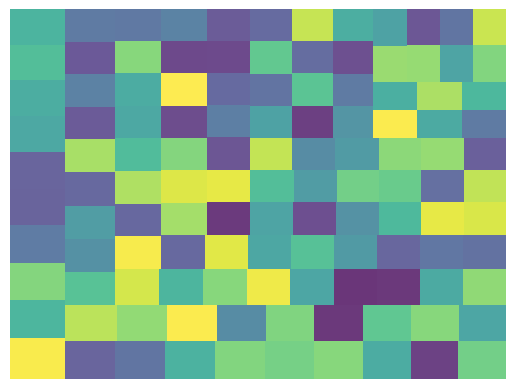

In [5]:
breed_counts = labels_df['breed'].value_counts()
breed_df = pd.DataFrame({'Breed': breed_counts.index, 'Count': breed_counts.values})
squarify.plot(sizes=breed_df['Count'], alpha=.8)
plt.axis('off')
plt.show()

In [6]:
dog_breeds = sorted(list(set(labels_df['breed'])))
n_classes = len(dog_breeds)
class_to_num = dict(zip(dog_breeds, range(n_classes)))
train_dir = '/root/project/data/train/'
test_dir = '/root/project/data/test/'

# Importing all the required tensorflow libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from sklearn.utils import shuffle
import gc

2023-03-10 01:56:05.825948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 01:56:06.374240: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 01:56:06.510812: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/local/hadoop/lib/native

# Model definition

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

2023-03-10 01:56:14.445193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/local/hadoop/lib/native:
2023-03-10 01:56:14.445222: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 01:56:14.445243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-1): /proc/driver/nvidia/version does not exist
2023-03-10 01:56:14.446199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuil

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining functions for loading images into Test and Train Data

In [ ]:
def load_train_images(dir_path):
    x_train, y_train = [], []
    for img_path in os.listdir(dir_path):
        img = load_img(os.path.join(dir_path, img_path), target_size=(128, 128, 1))
        x_train.append(preprocess_input(np.array(img).astype("float32")))
        img_name = img_path.split('/')[-1].split('.')[0]
        class_id = class_to_num[labels_df[labels_df['id'] == img_name]['breed'].values[0]]
        y_train.append(class_id)
    x_train = np.array(x_train)
    y_train = to_categorical(y_train, num_classes=n_classes)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, y_train

In [ ]:
def load_test_images(dir_path):
    x_test = []
    for img_path in os.listdir(dir_path):
        img = load_img(os.path.join(dir_path, img_path), target_size=(128, 128, 1))
        x_test.append(preprocess_input(np.array(img).astype("float32")))
    x_test = np.array(x_test)
    return x_test

In [ ]:
x_train, y_train = load_train_images(train_dir)
print(x_train.shape)
print(y_train.shape)

(10222, 128, 128, 3)
(10222, 120)


In [ ]:
x_test = load_test_images(test_dir)
print(x_test.shape)

(10357, 128, 128, 3)


# Fitting the data to the model

In [ ]:
history10 = model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
160/160 [==============================] - 103s 623ms/step - loss: 3.2934 - accuracy: 0.2643
Epoch 2/10
160/160 [==============================] - 102s 635ms/step - loss: 2.1057 - accuracy: 0.4460
Epoch 3/10
160/160 [==============================] - 101s 630ms/step - loss: 1.8140 - accuracy: 0.5033
Epoch 4/10
160/160 [==============================] - 100s 625ms/step - loss: 1.6076 - accuracy: 0.5515
Epoch 5/10
160/160 [==============================] - 100s 622ms/step - loss: 1.4484 - accuracy: 0.5882
Epoch 6/10
160/160 [==============================] - 100s 622ms/step - loss: 1.3144 - accuracy: 0.6172
Epoch 7/10
160/160 [==============================] - 99s 620ms/step - loss: 1.1931 - accuracy: 0.6476
Epoch 8/10
160/160 [==============================] - 102s 637ms/step - loss: 1.0960 - accuracy: 0.6711
Epoch 9/10
160/160 [==============================] - 100s 625ms/step - loss: 1.0094 - accuracy: 0.6929
Epoch 10/10
160/160 [==============================] - 100s 626ms

In [ ]:
history30 = model.fit(x_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
80/80 [==============================] - 95s 1s/step - loss: 0.7032 - accuracy: 0.7805
Epoch 2/10
80/80 [==============================] - 94s 1s/step - loss: 0.5573 - accuracy: 0.8207
Epoch 3/10
80/80 [==============================] - 95s 1s/step - loss: 0.5029 - accuracy: 0.8325
Epoch 4/10
80/80 [==============================] - 97s 1s/step - loss: 0.4569 - accuracy: 0.8530
Epoch 5/10
80/80 [==============================] - 94s 1s/step - loss: 0.4187 - accuracy: 0.8702
Epoch 6/10
80/80 [==============================] - 95s 1s/step - loss: 0.3831 - accuracy: 0.8767
Epoch 7/10
80/80 [==============================] - 95s 1s/step - loss: 0.3812 - accuracy: 0.8774
Epoch 8/10
80/80 [==============================] - 95s 1s/step - loss: 0.3573 - accuracy: 0.8845
Epoch 9/10
80/80 [==============================] - 95s 1s/step - loss: 0.3247 - accuracy: 0.8942
Epoch 10/10
80/80 [==============================] - 97s 1s/step - loss: 0.3080 - accuracy: 0.8999


In [ ]:
history25 = model.fit(x_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
160/160 [==============================] - 100s 622ms/step - loss: 0.5742 - accuracy: 0.8139
Epoch 2/25
160/160 [==============================] - 99s 621ms/step - loss: 0.7185 - accuracy: 0.7744
Epoch 3/25
160/160 [==============================] - 100s 624ms/step - loss: 0.7140 - accuracy: 0.7753
Epoch 4/25
160/160 [==============================] - 99s 616ms/step - loss: 0.6528 - accuracy: 0.7966
Epoch 5/25
160/160 [==============================] - 98s 615ms/step - loss: 0.5768 - accuracy: 0.8142
Epoch 6/25
160/160 [==============================] - 99s 619ms/step - loss: 0.5519 - accuracy: 0.8182
Epoch 7/25
160/160 [==============================] - 99s 620ms/step - loss: 0.5161 - accuracy: 0.8376
Epoch 8/25
160/160 [==============================] - 100s 622ms/step - loss: 0.4813 - accuracy: 0.8471
Epoch 9/25
160/160 [==============================] - 101s 629ms/step - loss: 0.4648 - accuracy: 0.8490
Epoch 10/25
160/160 [==============================] - 100s 624ms/ste

In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
160/160 [==============================] - 100s 623ms/step - loss: 0.3269 - accuracy: 0.8945
Epoch 2/50
160/160 [==============================] - 101s 628ms/step - loss: 0.3386 - accuracy: 0.8953
Epoch 3/50
160/160 [==============================] - 101s 630ms/step - loss: 0.3050 - accuracy: 0.9041
Epoch 4/50
160/160 [==============================] - 100s 626ms/step - loss: 0.3289 - accuracy: 0.8987
Epoch 5/50
160/160 [==============================] - 100s 623ms/step - loss: 0.3263 - accuracy: 0.9022
Epoch 6/50
160/160 [==============================] - 100s 623ms/step - loss: 0.3297 - accuracy: 0.9009
Epoch 7/50
160/160 [==============================] - 100s 623ms/step - loss: 0.3097 - accuracy: 0.9035
Epoch 8/50
160/160 [==============================] - 101s 631ms/step - loss: 0.2790 - accuracy: 0.9150
Epoch 9/50
160/160 [==============================] - 101s 629ms/step - loss: 0.2899 - accuracy: 0.9114
Epoch 10/50
160/160 [==============================] - 99s 620ms

# Plotting the evaluation metrics of the Model

In [ ]:
def plot_model_history(history, fig_title, shape=(24,6)):
    fig, ax = plt.subplots(1,2, figsize=shape)
    fig.suptitle(fig_title, fontsize=16)
    ax[0].plot(history.history['loss'],     color='b', label="Training loss")
    #ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.history['accuracy'],     color='b', label="Training accuracy")
    #ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.show()

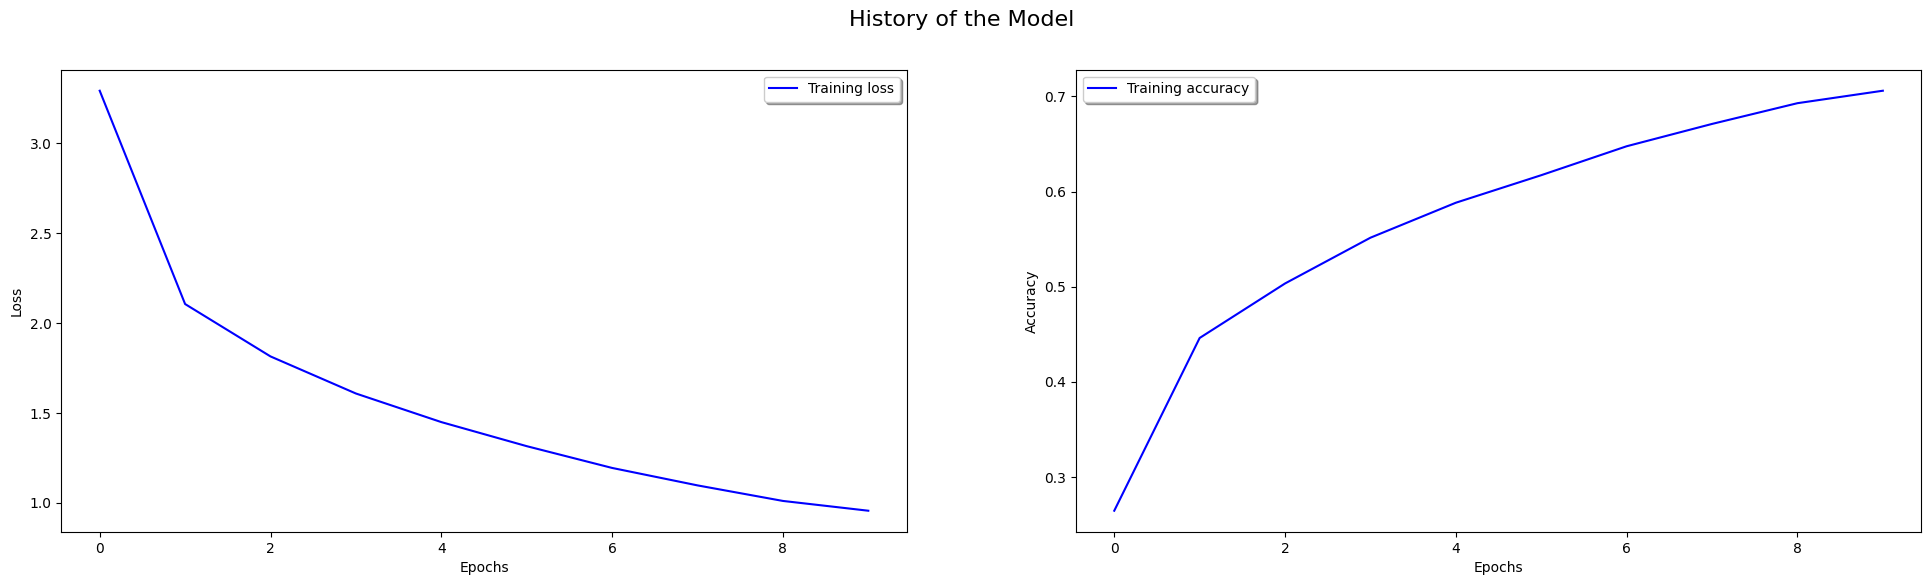

In [ ]:
plot_model_history(history10, 'History of the Model')

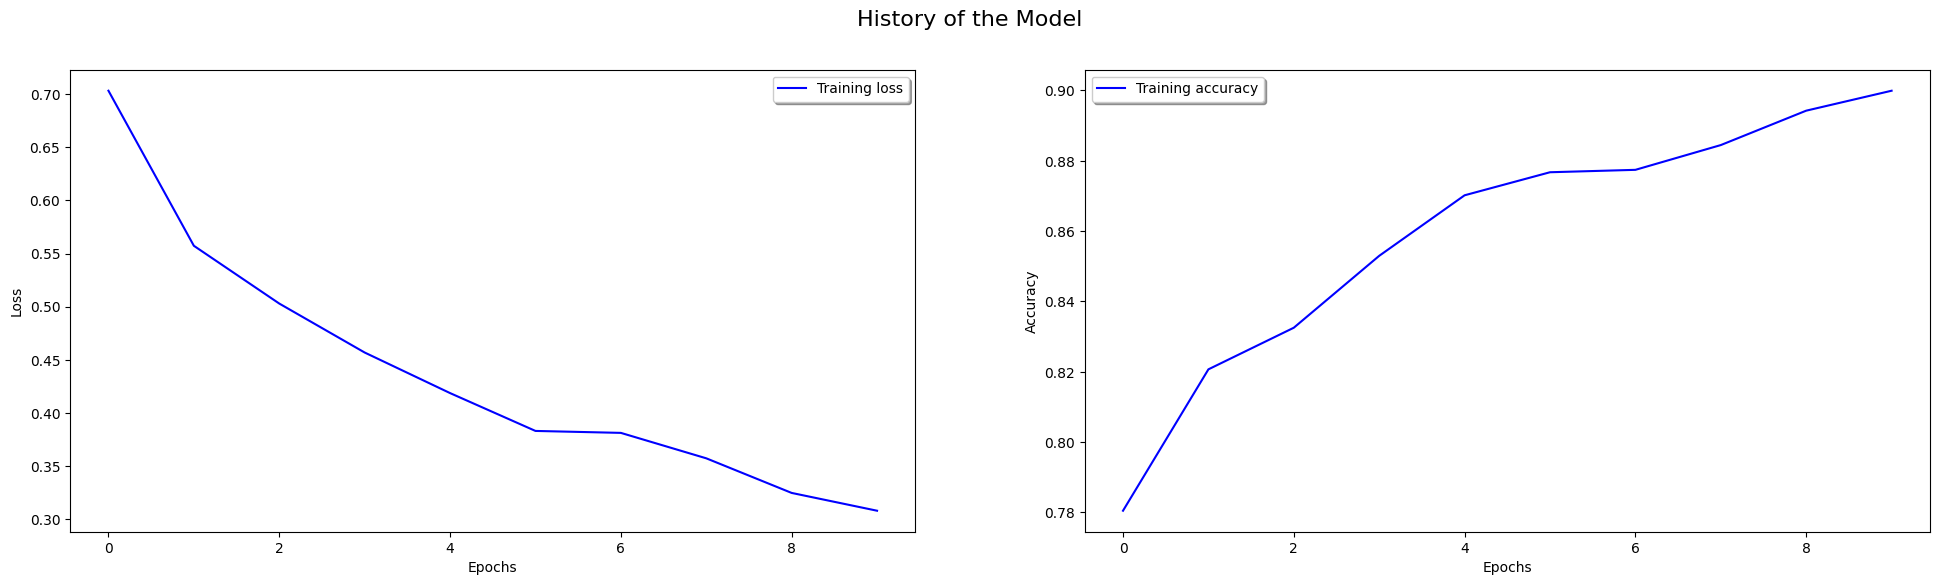

In [ ]:
plot_model_history(history30, 'History of the Model')

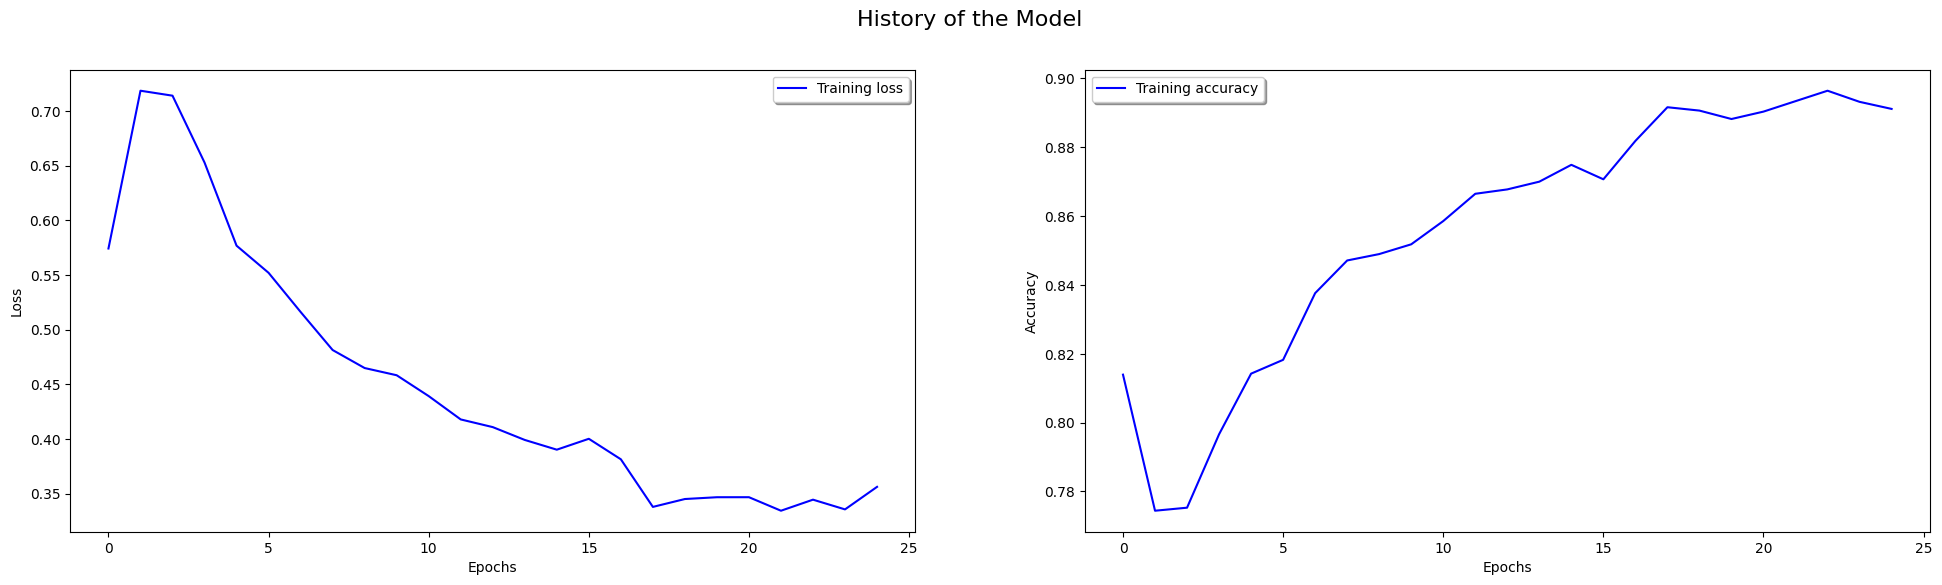

In [ ]:
plot_model_history(history25, 'History of the Model')

In [ ]:
plot_model_history(history, 'History of the Model')